In [1]:
import numpy as np
import matplotlib.pylab as plt
from gf45clo_sin_neff_ng_calculator import mode_data_calculator

import tidy3d as td
from tidy3d.constants import C_0

from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")


In [2]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.05

min_steps_per_wvl = 20

wg_width = 0.44
wg_height = 0.3
wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

sidewall_angle = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 5

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

In [3]:
mode_solver, mode_data_df = mode_data_calculator(
    wg_width, wg_height, sidewall_angle, wg_n, wg_k, freqs, freq0, Lx=Lx, Ly=Ly, Lz=Lz, dl=dl, min_steps_per_wvl=min_steps_per_wvl
    )


[23:18:02] WARNING: Use the remote mode solver with subpixel averaging for      
           better accuracy through 'tidy3d.plugins.mode.web.run(...)'.          

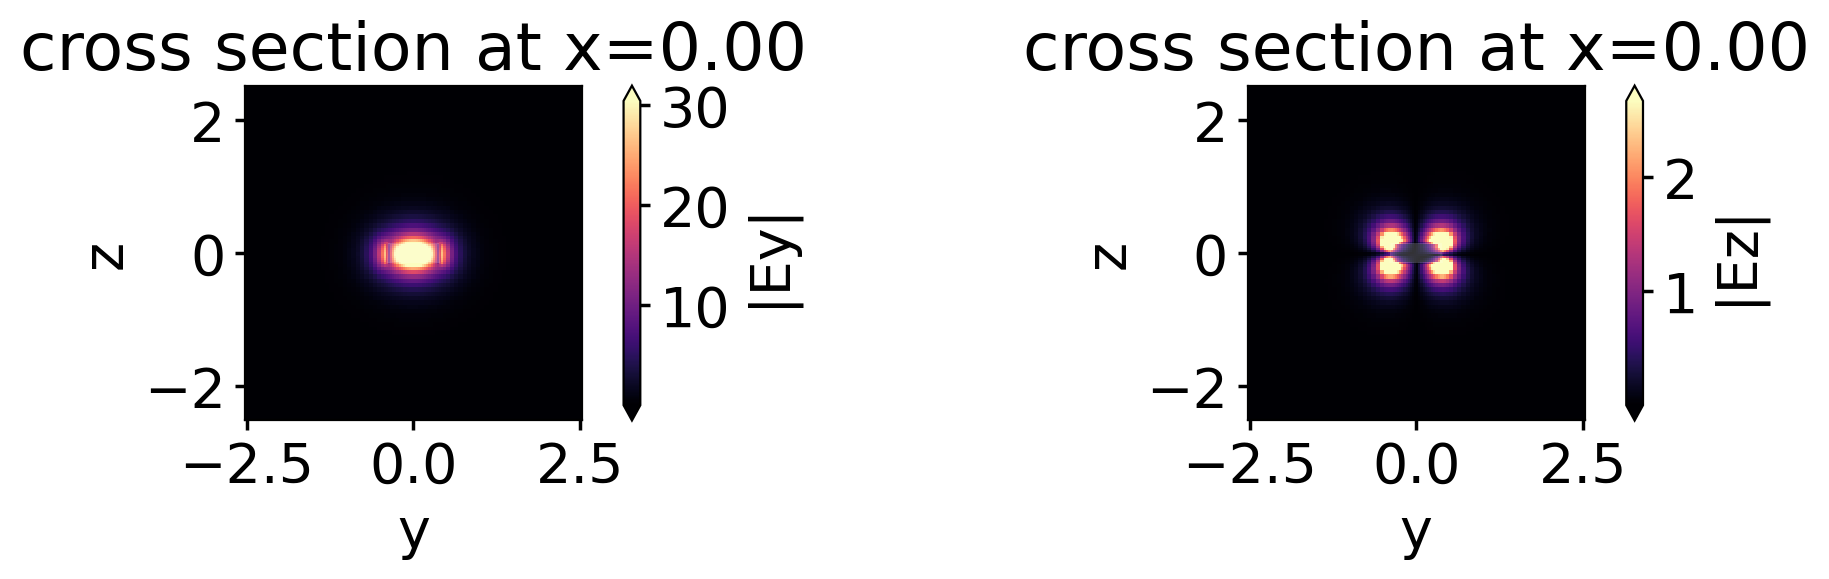

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
mode_solver.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
plt.show()


In [5]:
## Calculating the group index

fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
ng_freq0 = fundamental_mode_data_df["group index"].values[0]
ng_dfreq = (mode_data_df["group index"].values[-1] - mode_data_df["group index"].values[0])/2
neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
neff_dfreq = (mode_data_df["n eff"].values[-1] - mode_data_df["n eff"].values[0])/2
print(ng_freq0, ng_dfreq, neff_freq0, neff_dfreq)

2.1559577 0.0011647939682006836 1.4155129 0.005176186561584473


In [6]:
thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 2000

wg_height_spread, wg_width_spread, wg_sidewall_angle_spread = [], [], []

for i in tqdm(range(num_samples),desc = "variation sweep"):
  wg_height_spread.append(
    (1+np.random.normal(0, thickness_3sigma/3/wg_height)) * wg_height
  )
  wg_width_spread.append(
    (1+np.random.normal(0, width_3sigma/3/wg_width)) * wg_width
  )
  wg_sidewall_angle_spread.append(
    (1+np.random.normal(0,sidewall_angle_3sigma/3/sidewall_angle)) * sidewall_angle
  )


variation sweep: 100%|██████████| 2000/2000 [00:00<00:00, 532035.77it/s]


In [7]:
print(np.median(wg_sidewall_angle_spread), 3 *np.std(wg_sidewall_angle_spread), sidewall_angle)
print(np.median(wg_height_spread), 3*np.std(wg_height_spread), wg_height)
print(np.median(wg_width_spread), 3*np.std(wg_width_spread),wg_width)


0.05204062192354414 0.03501429105268666 0.05235987755982996
0.2997421899222955 0.030349652385086655 0.3
0.8000626908501463 0.02011727757229418 0.8


In [8]:
wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []
permutation_choice_width, permutation_choice_height, permutation_choice_sidewall_angle = np.random.permutation(num_samples), np.random.permutation(num_samples), np.random.permutation(num_samples)

for i in tqdm(range(num_samples), desc="mode_simulations"):
  rand_wg_width_choice = wg_width_spread[permutation_choice_width[i]]
  rand_wg_height_choice = wg_height_spread[permutation_choice_height[i]]
  rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[i]]

  wg_width_choice.append(rand_wg_width_choice)
  wg_height_choice.append(rand_wg_height_choice)
  wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

  mode_solver, mode_data_df = mode_data_calculator(
      rand_wg_width_choice, 
      rand_wg_height_choice, 
      rand_wg_sidewall_angle_choice, 
      wg_n, wg_k, freqs, freq0, 
      Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
      min_steps_per_wvl=min_steps_per_wvl
  )

  fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
  ng_freq0 = fundamental_mode_data_df["group index"].values[0]
  ng_dfreq = (mode_data_df["group index"].values[-1] -
              mode_data_df["group index"].values[0])/2
  neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
  neff_dfreq = (mode_data_df["n eff"].values[-1] -
                mode_data_df["n eff"].values[0])/2
  
  ng_freq0_spread.append(ng_freq0)
  ng_dfreq_spread.append(ng_dfreq)
  neff_freq0_spread.append(neff_freq0)
  neff_dfreq_spread.append(neff_dfreq)

  if i%20 == 0:
    gf45clo_sin_neff_ng_variability = pd.DataFrame(data=wg_width_choice)

    gf45clo_sin_neff_ng_variability.columns = ['wg_width (nm)']
    gf45clo_sin_neff_ng_variability['wg_height (nm)']=wg_height_choice
    gf45clo_sin_neff_ng_variability['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
    gf45clo_sin_neff_ng_variability['neff_freq0'] = neff_freq0_spread
    gf45clo_sin_neff_ng_variability['neff_dfreq'] = neff_dfreq_spread
    gf45clo_sin_neff_ng_variability['ng_freq0'] = ng_freq0_spread
    gf45clo_sin_neff_ng_variability['ng_dfreq'] = ng_dfreq_spread
    gf45clo_sin_neff_ng_variability['freq0 (Hz)']=freq0
    gf45clo_sin_neff_ng_variability['freq_lo (Hz)'] = freqs[0]
    gf45clo_sin_neff_ng_variability['freq_hi (Hz)'] = freqs[-1]

    gf45clo_sin_neff_ng_variability.to_csv("gf45clo_sin_neff_ng_variability.csv")

mode_simulations: 100%|██████████| 2000/2000 [2:05:29<00:00,  3.76s/it]  


Text(0.5, 1.0, 'Median = 87.02 deg, 1-sigma = 0.67 deg')

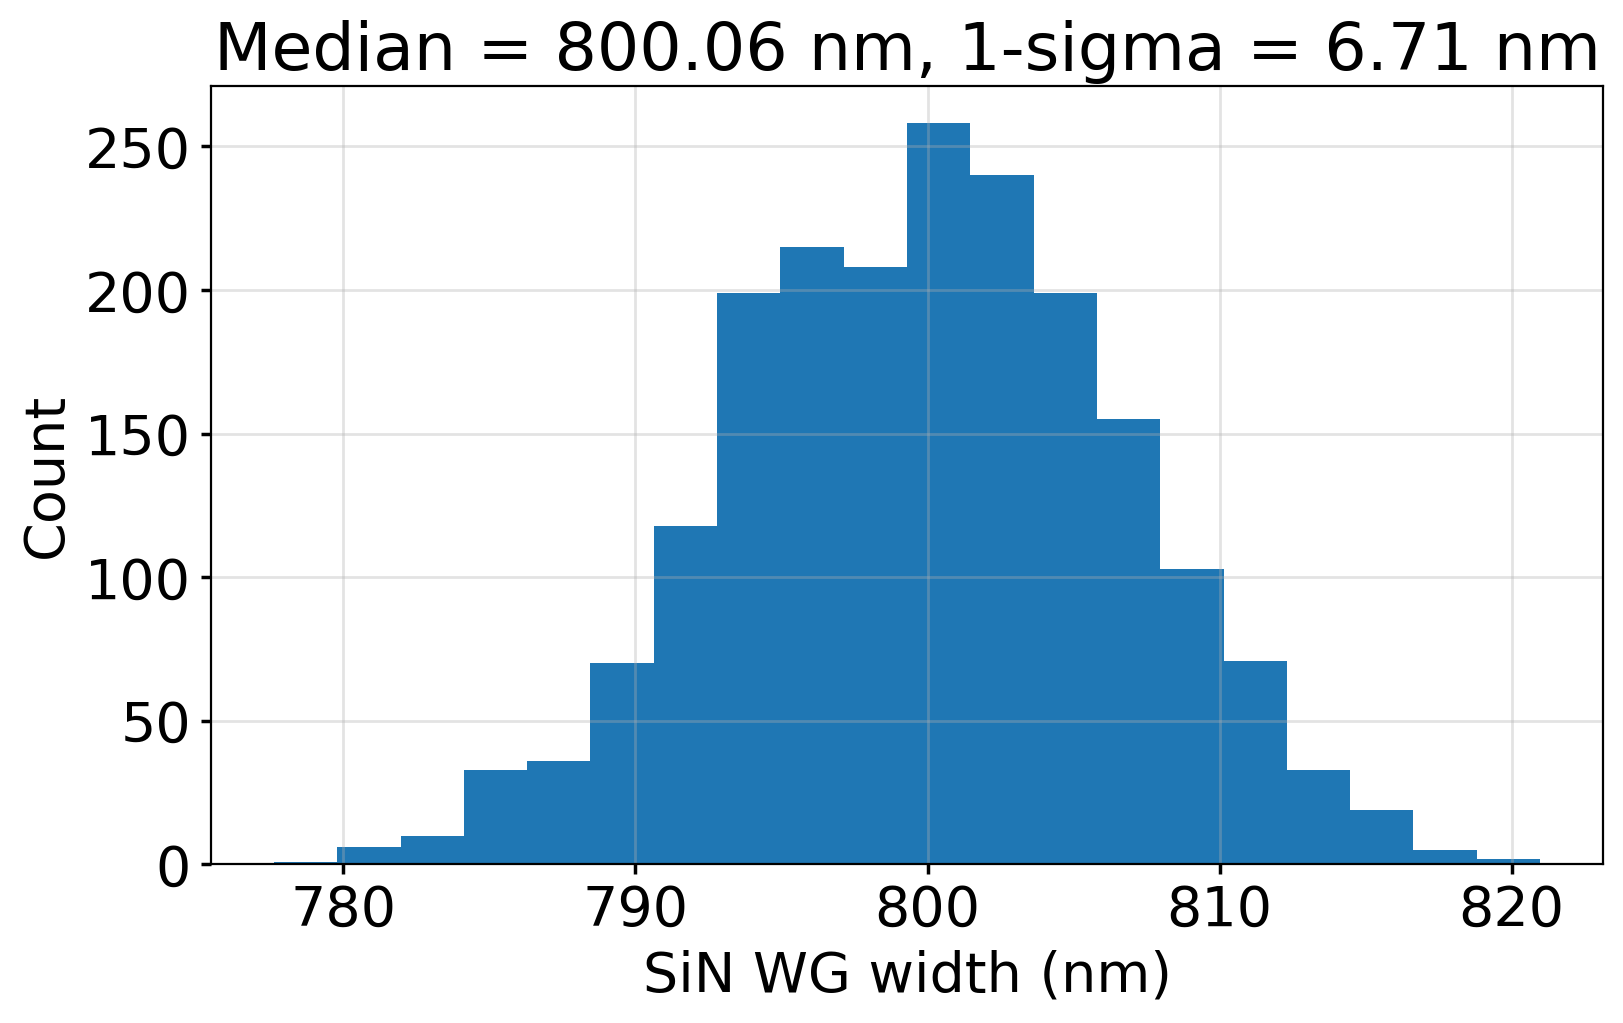

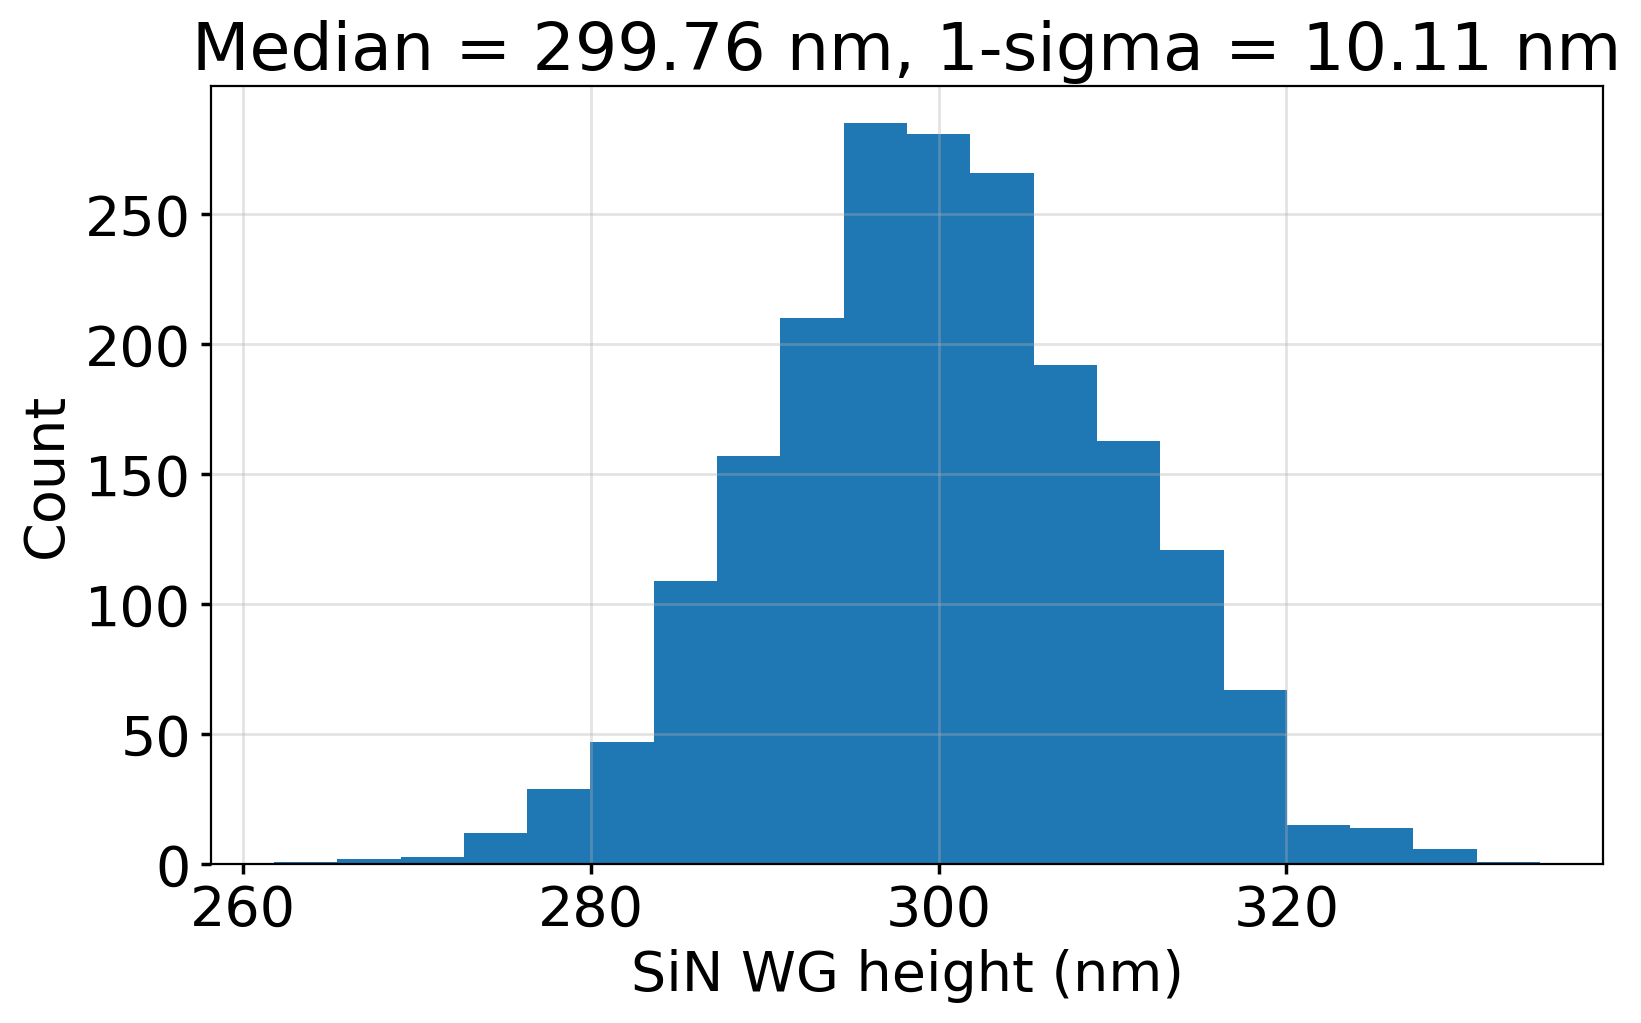

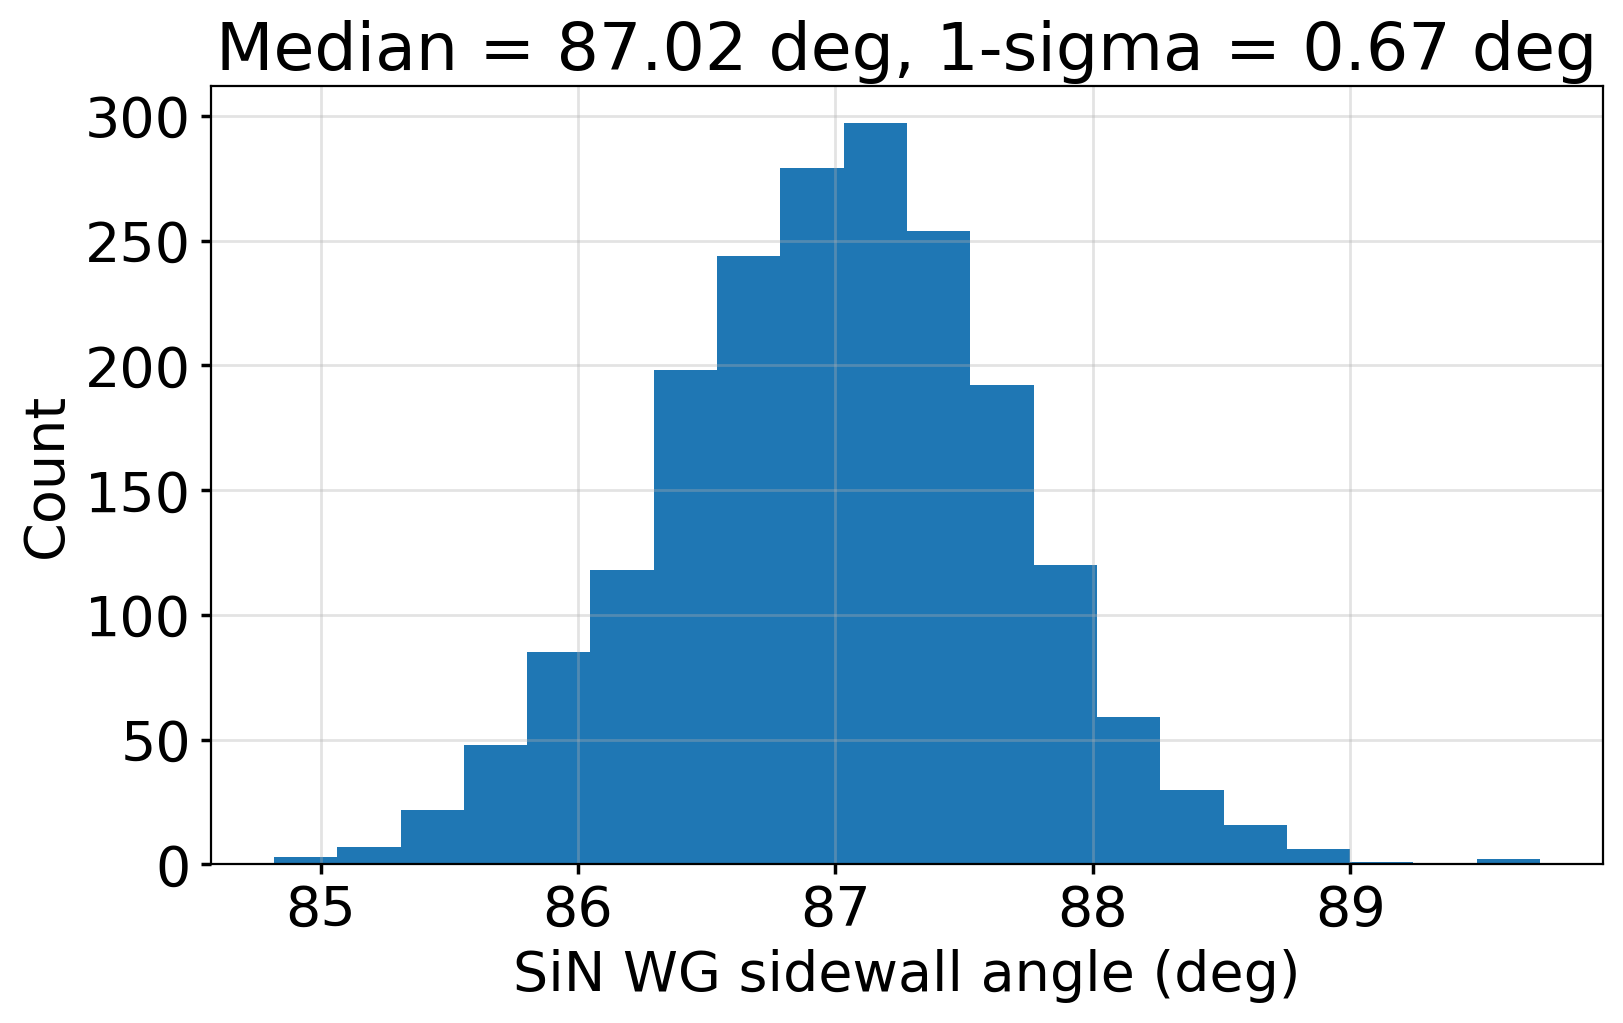

In [9]:
plt.figure()
plt.hist(gf45clo_sin_neff_ng_variability["wg_width (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG width (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(gf45clo_sin_neff_ng_variability["wg_width (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(gf45clo_sin_neff_ng_variability["wg_width (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(gf45clo_sin_neff_ng_variability["wg_height (nm)"]*1000, bins=20)
plt.grid(True)
plt.xlabel('SiN WG height (nm)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(gf45clo_sin_neff_ng_variability["wg_height (nm)"]*1000):0.2f} nm, 1-sigma = {np.std(gf45clo_sin_neff_ng_variability["wg_height (nm)"]*1000):0.2f} nm')

plt.figure()
plt.hist(
    90-gf45clo_sin_neff_ng_variability["wg_sidewall_angle (rad)"].values/np.pi*180, bins=20)
plt.grid(True)
plt.xlabel('SiN WG sidewall angle (deg)')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(90-gf45clo_sin_neff_ng_variability["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg, 1-sigma = {np.std(90-gf45clo_sin_neff_ng_variability["wg_sidewall_angle (rad)"].values/np.pi*180):0.2f} deg')


Text(0.5, 1.0, 'Median = 2.1557, 1-sigma = 0.0106')

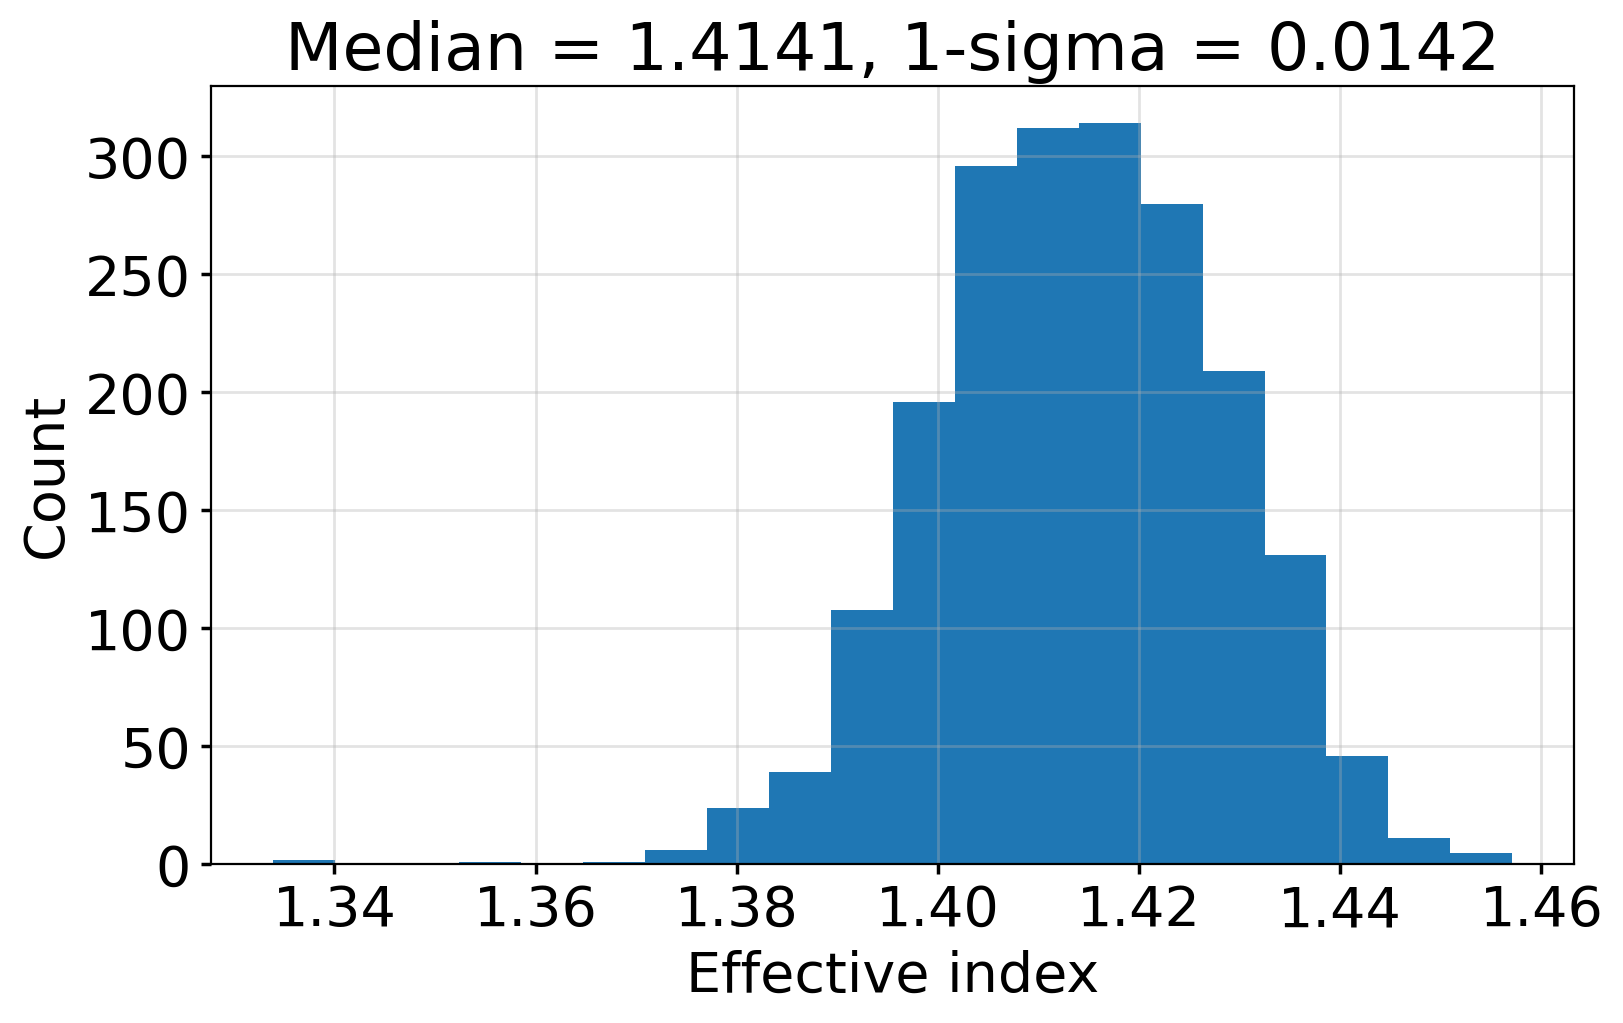

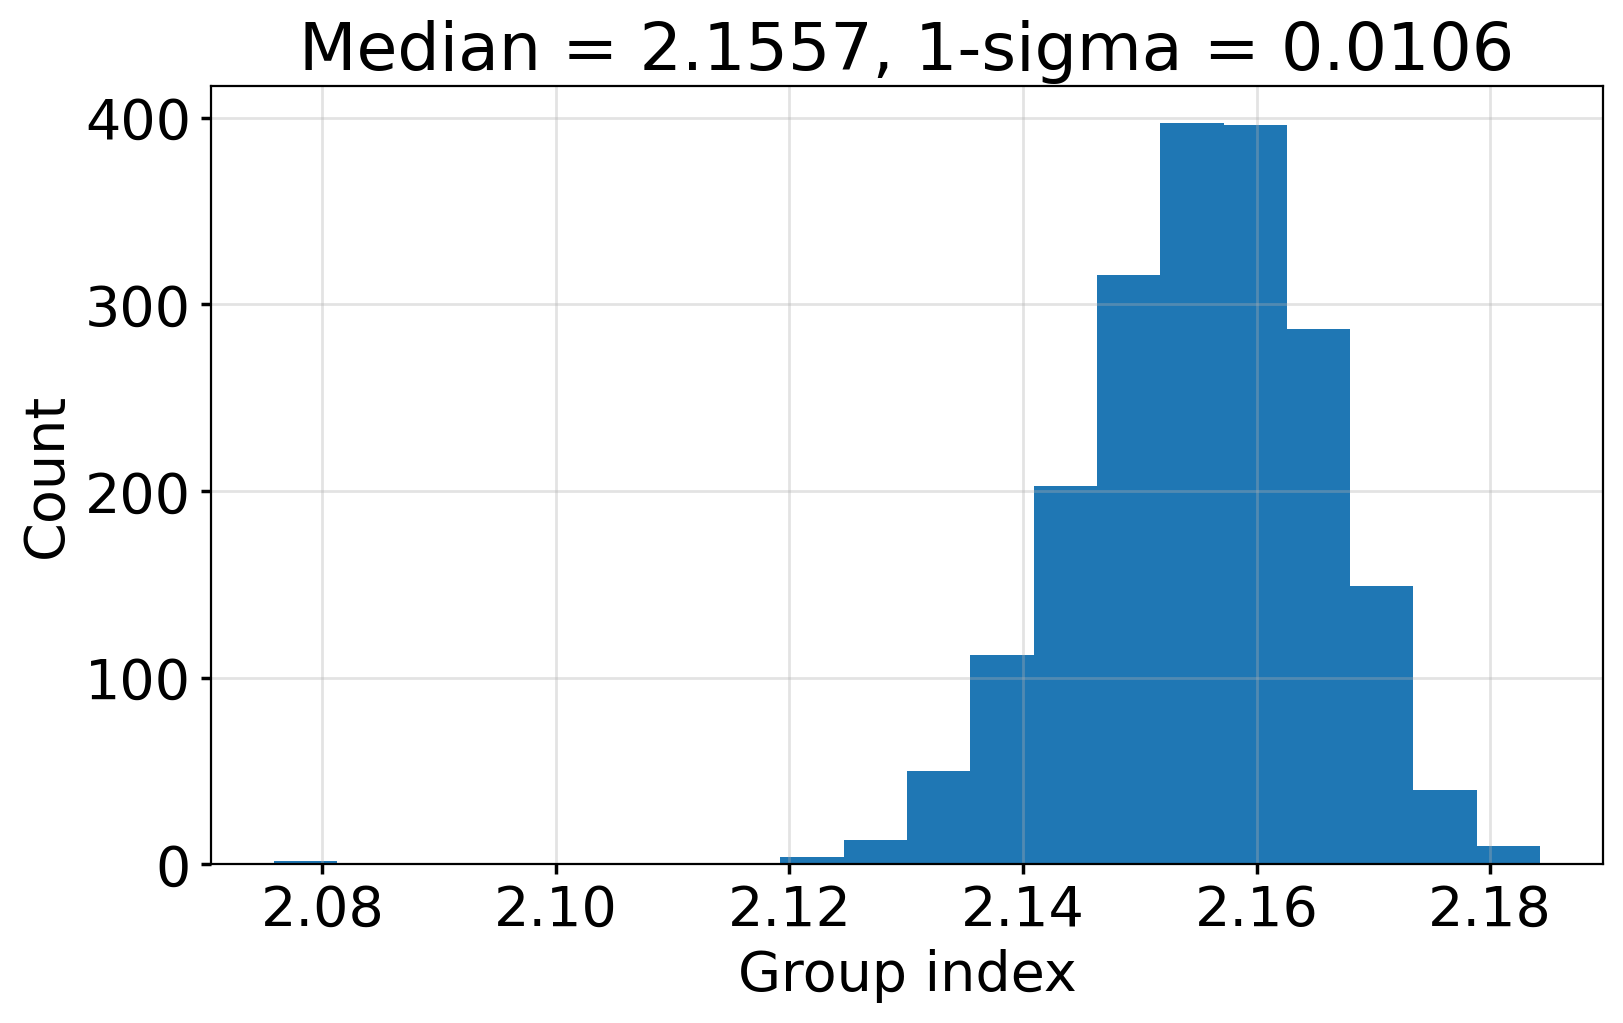

In [11]:
plt.figure()
plt.hist(gf45clo_sin_neff_ng_variability["neff_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Effective index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(gf45clo_sin_neff_ng_variability["neff_freq0"]):0.4f}, 1-sigma = {np.std(gf45clo_sin_neff_ng_variability["neff_freq0"]):0.4f}')

plt.figure()
plt.hist(gf45clo_sin_neff_ng_variability["ng_freq0"], bins=20)
plt.grid(True)
plt.xlabel('Group index')
plt.ylabel('Count')
plt.title(
    f'Median = {np.median(gf45clo_sin_neff_ng_variability["ng_freq0"]):0.4f}, 1-sigma = {np.std(gf45clo_sin_neff_ng_variability["ng_freq0"]):0.4f}')
